##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 2.57
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines
import pandas
print(pandas.__version__)
#!pip install --upgrade pandas

1.1.5


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.49;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

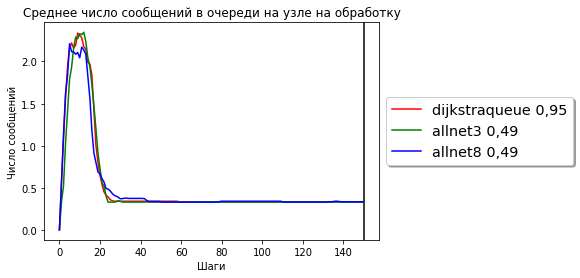

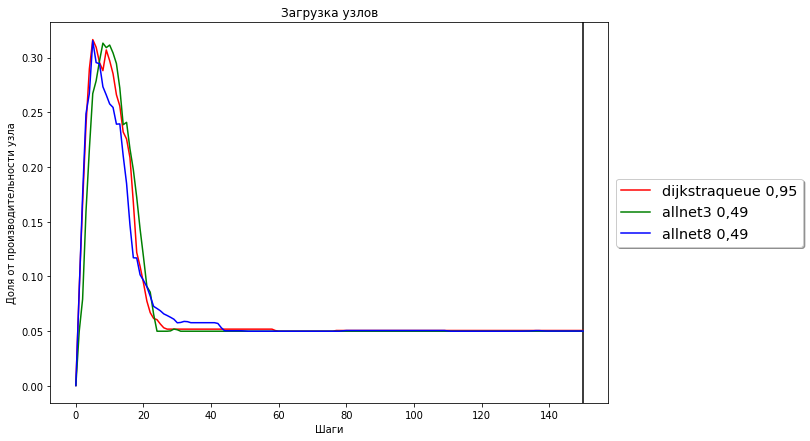

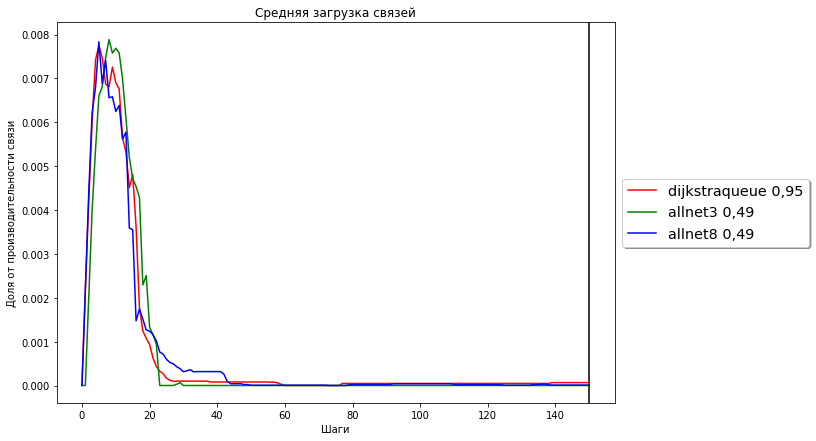

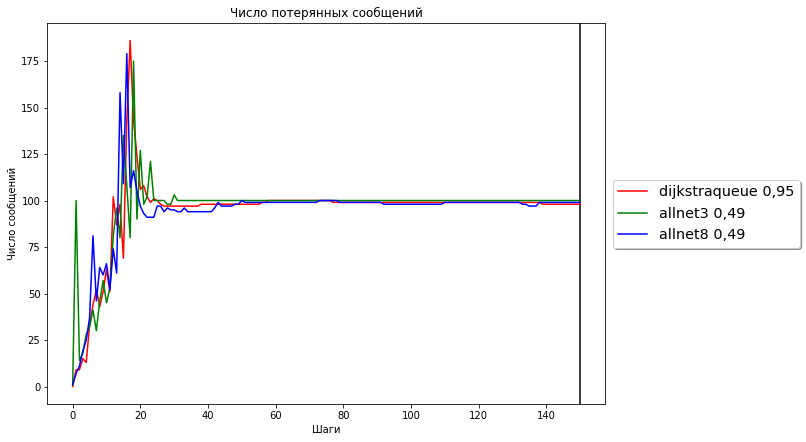

Доставлено 709 Потеряно 95.2736% -dijkstraqueue 0,95
Доставлено 544 Потеряно 96.3736% -allnet3 0,49
Доставлено 791 Потеряно 94.7270% -allnet8 0,49


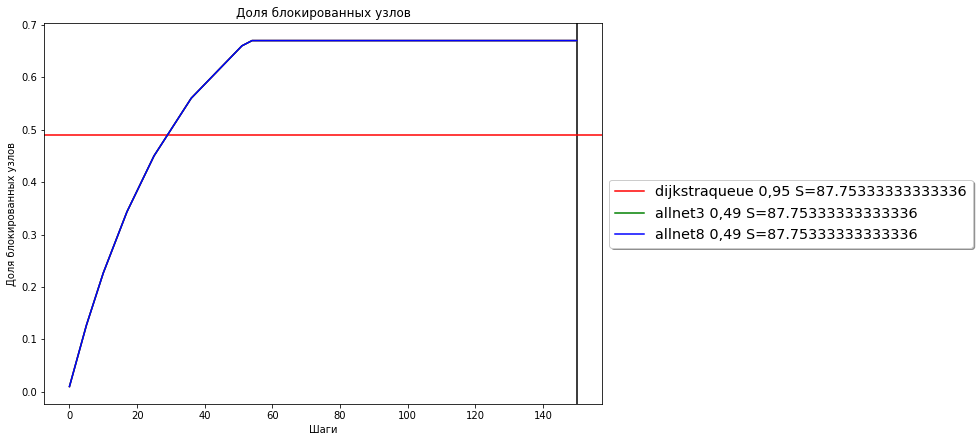

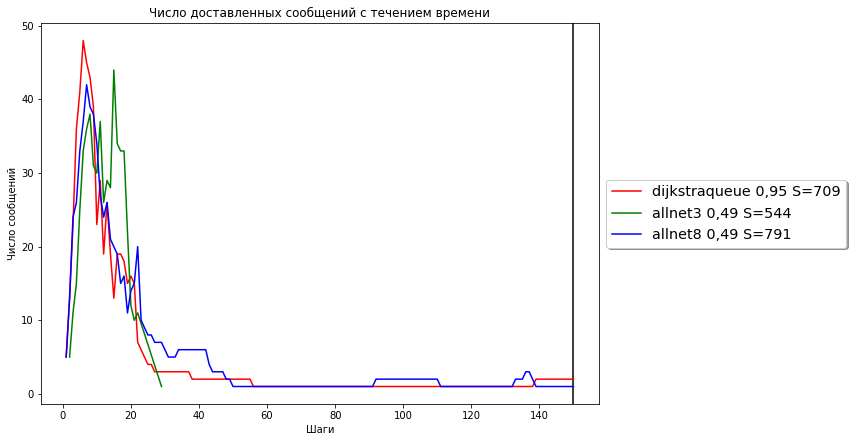

In [3]:
quantity = 100;
log_tags = [
{"tag":  "4df2ea8e-3333-417b-822d-238959dbf1f1", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "41a70eb4-b05e-4f10-ba44-36c653b08972", "label": "allnet3 0,49", "color": "green"},
{"tag":  "8613fff6-1dbb-4ec8-933c-bce4cb90d731", "label": "allnet8 0,49", "color": "blue"},

]

showStat()
showStatBlocked();  
showStatMessage(); 


<strong>Quantity 500 </strong>

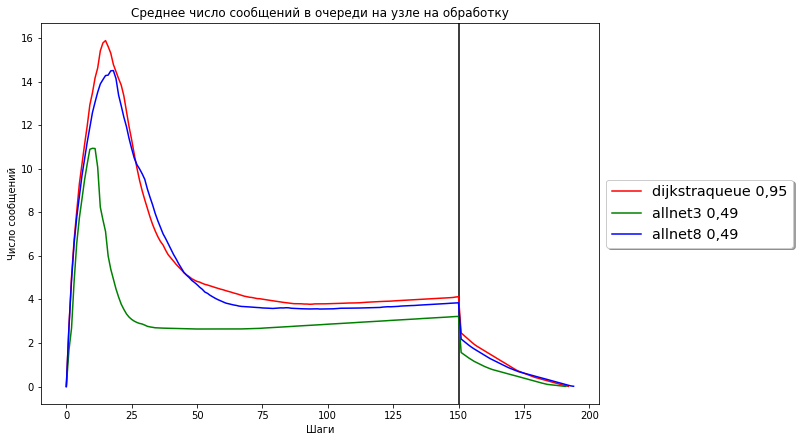

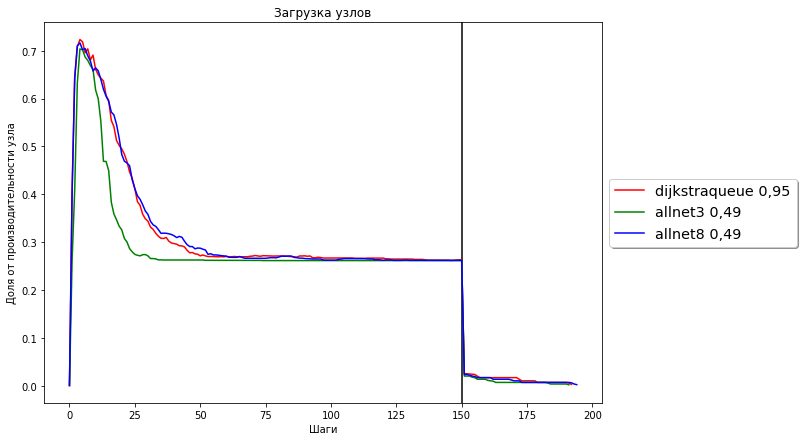

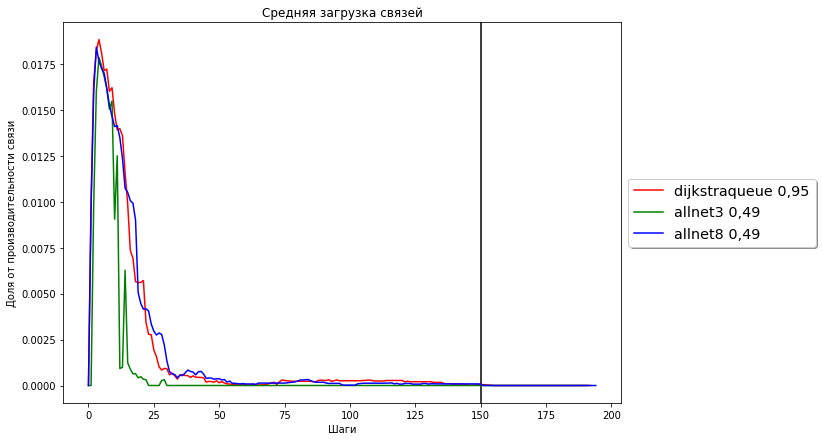

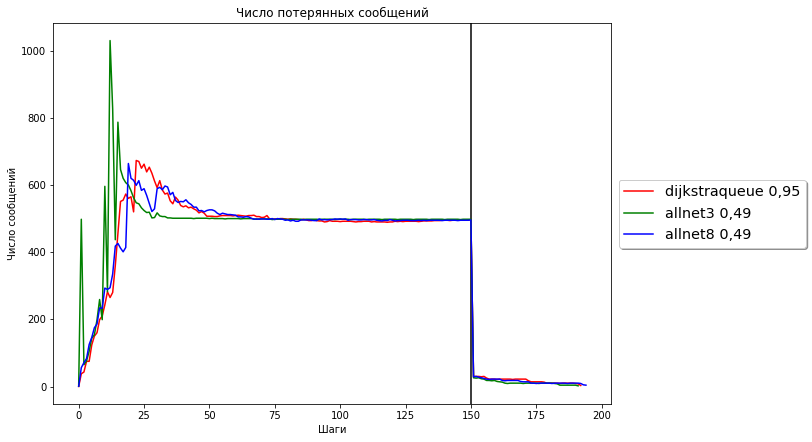

Доставлено 1665 Потеряно 97.7800% -dijkstraqueue 0,95
Доставлено 690 Потеряно 99.0800% -allnet3 0,49
Доставлено 1836 Потеряно 97.5520% -allnet8 0,49


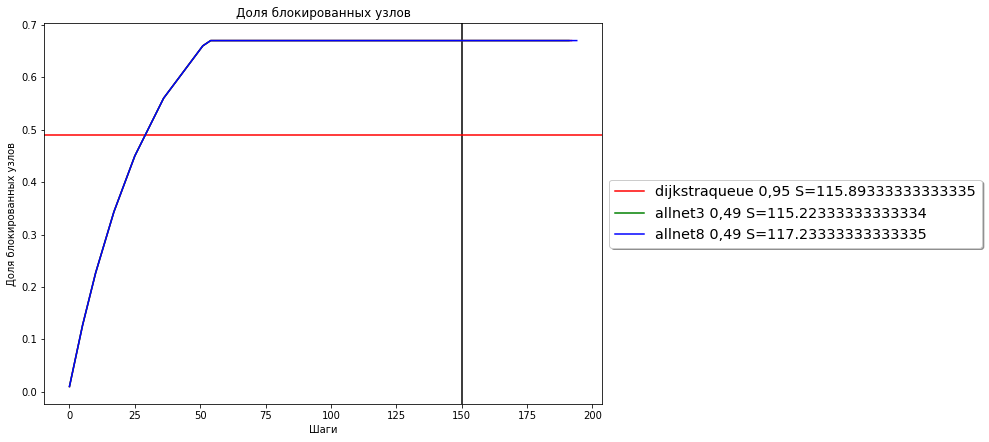

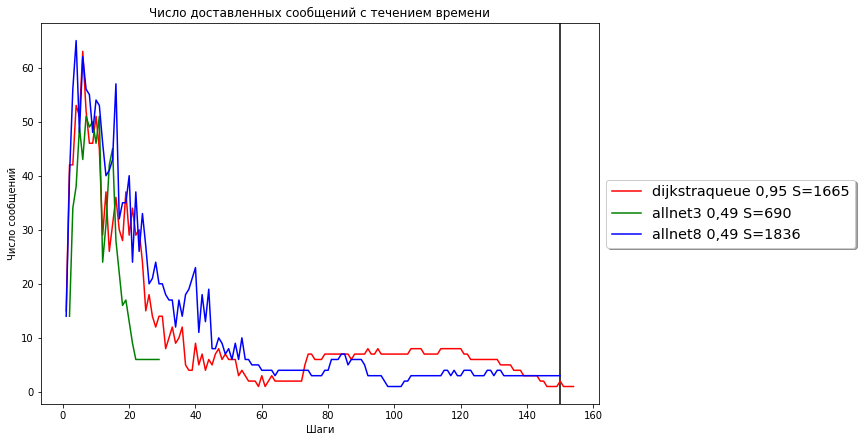

In [4]:
quantity = 500;
log_tags = [
{"tag":  "4a036b13-5426-4352-a92b-955cf280c623", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "c45280a2-be4c-4b56-930c-729f1f846744", "label": "allnet3 0,49", "color": "green"},
{"tag":  "cec88c42-3af0-40f6-99de-b80e56567f4b", "label": "allnet8 0,49", "color": "blue"},

]  
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

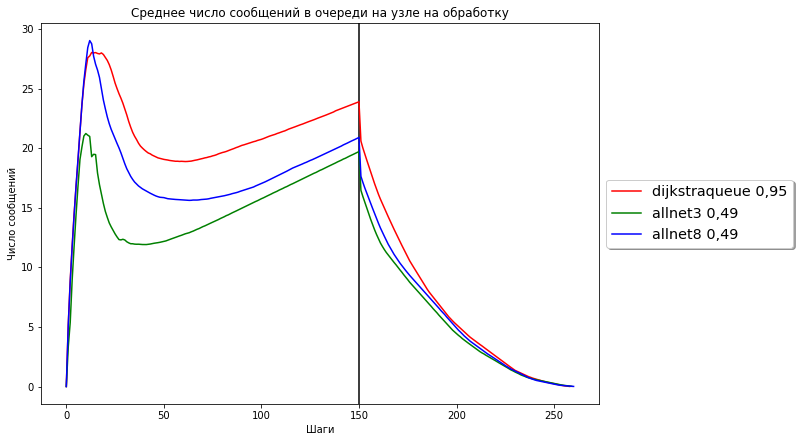

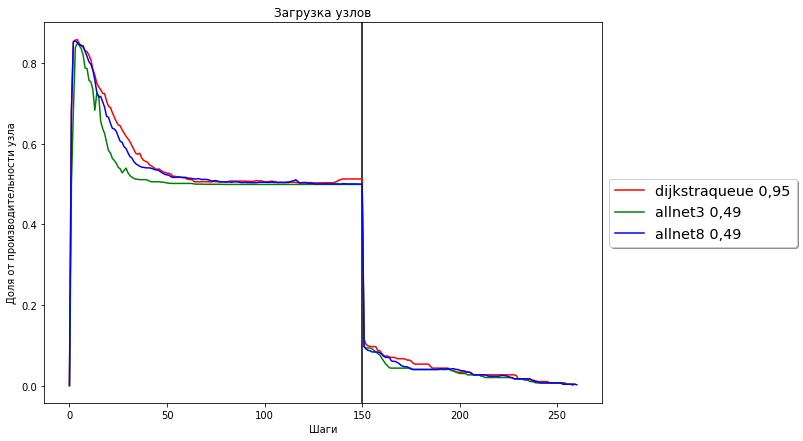

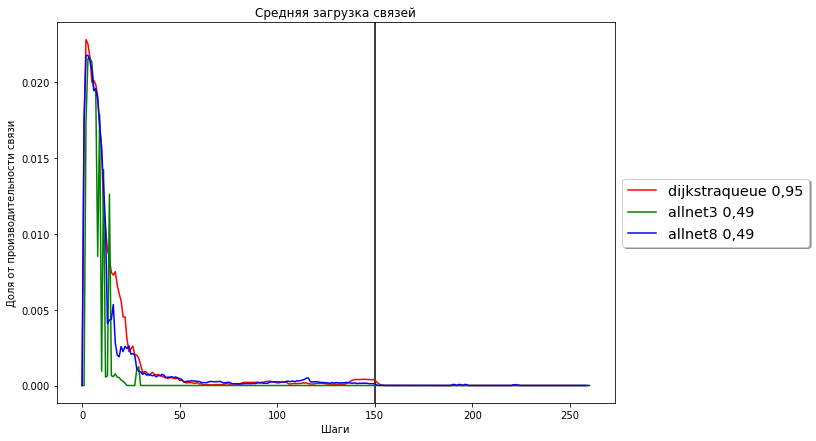

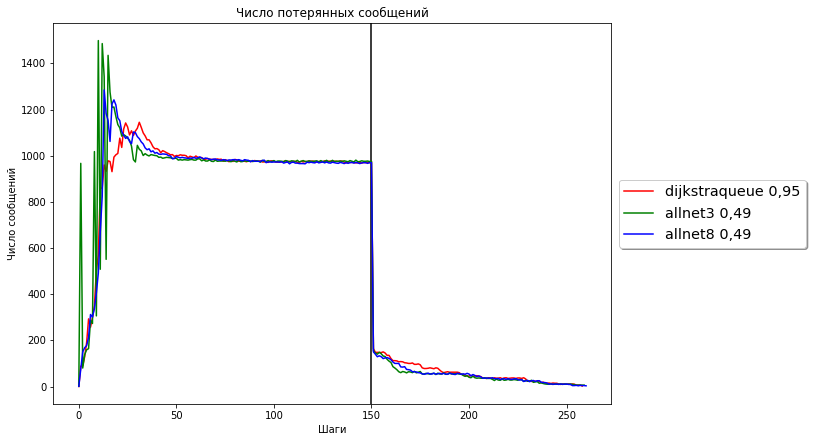

Доставлено 1853 Потеряно 98.7647% -dijkstraqueue 0,95
Доставлено 573 Потеряно 99.6180% -allnet3 0,49
Доставлено 2199 Потеряно 98.5340% -allnet8 0,49


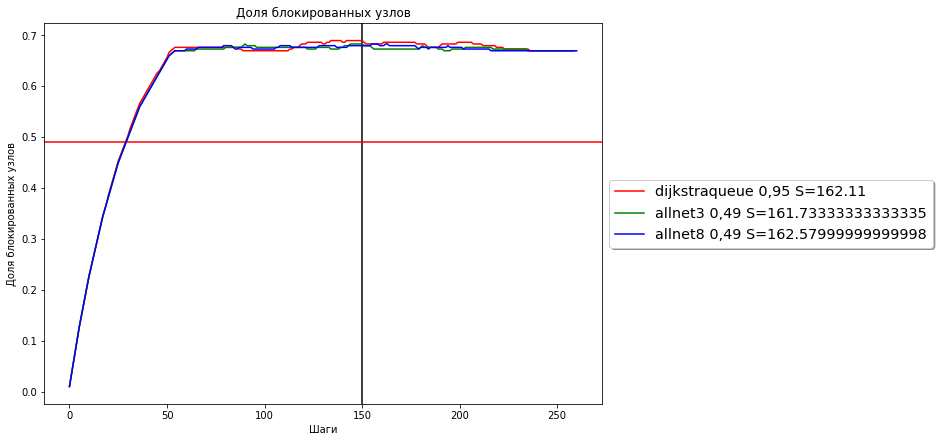

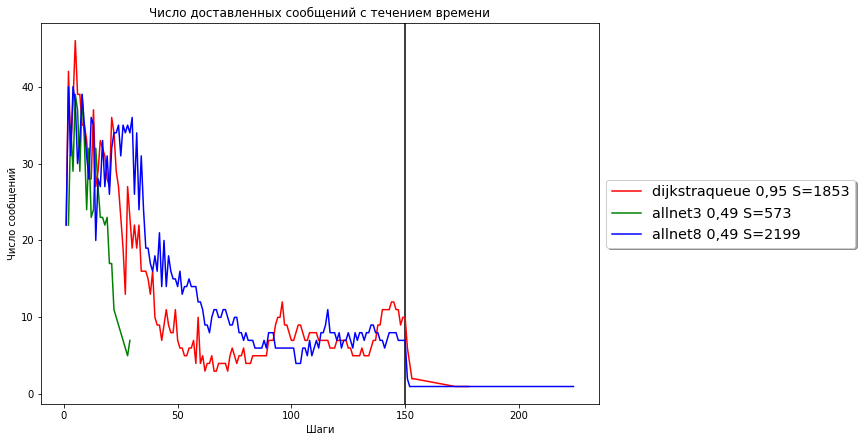

In [5]:
quantity = 1000;
log_tags = [
{"tag":  "b51c7b1d-fa36-404b-bfa1-bede967e59ba", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "fbc7a6b9-5808-4af0-ae9a-dffedbd3ef17", "label": "allnet3 0,49", "color": "green"},
{"tag":  "a3deb582-7cb1-4732-a7f8-026fbb53ed36", "label": "allnet8 0,49", "color": "blue"},

]  
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

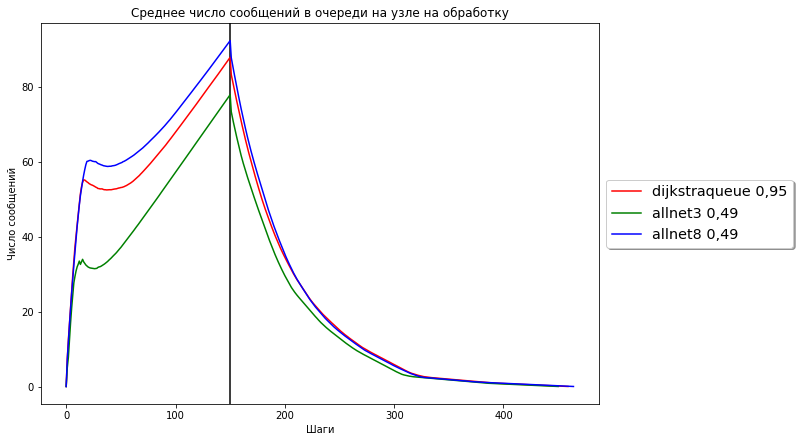

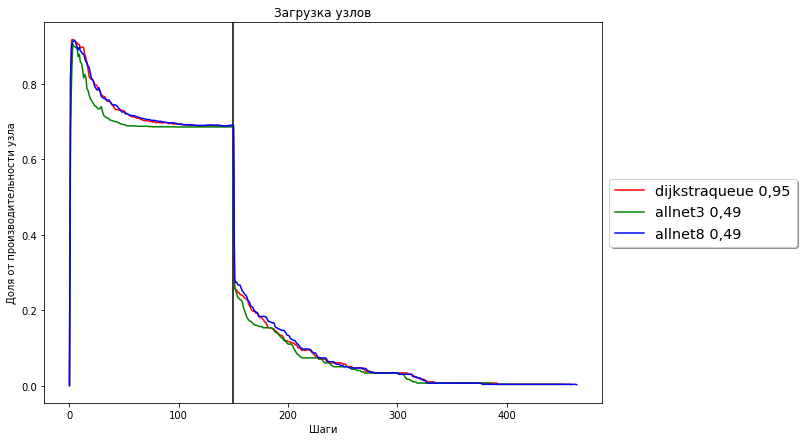

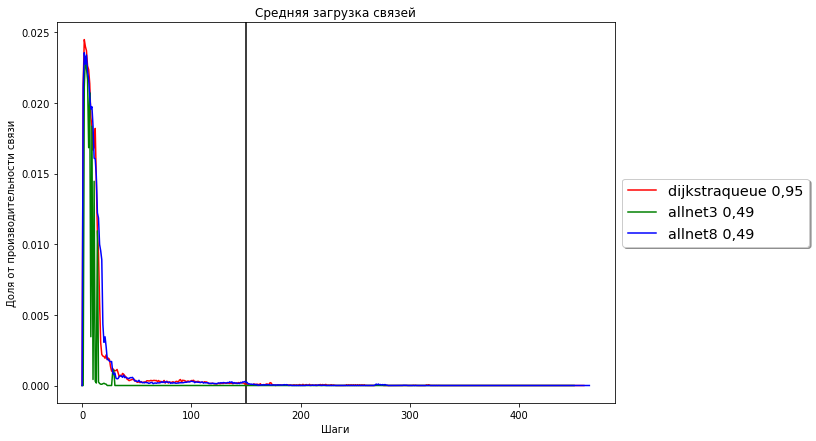

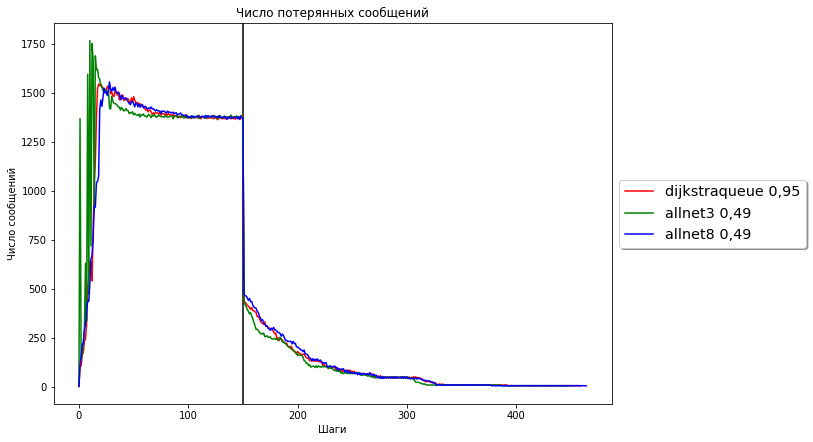

Доставлено 2359 Потеряно 98.9516% -dijkstraqueue 0,95
Доставлено 410 Потеряно 99.8178% -allnet3 0,49
Доставлено 2213 Потеряно 99.0164% -allnet8 0,49


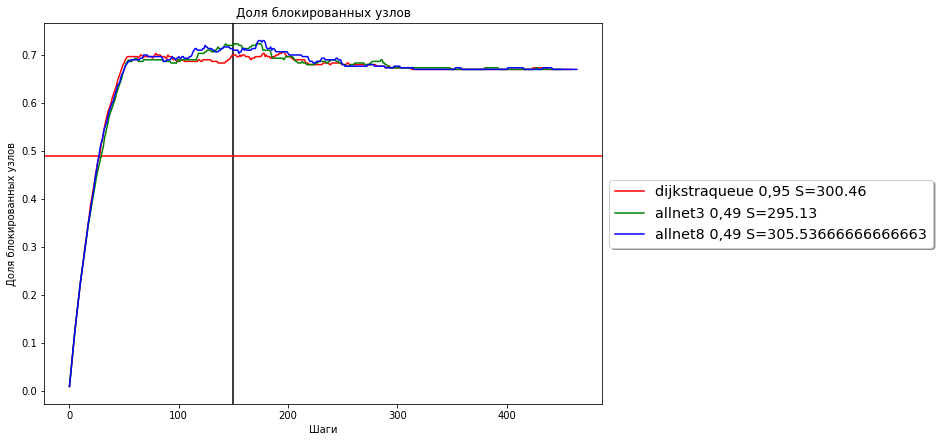

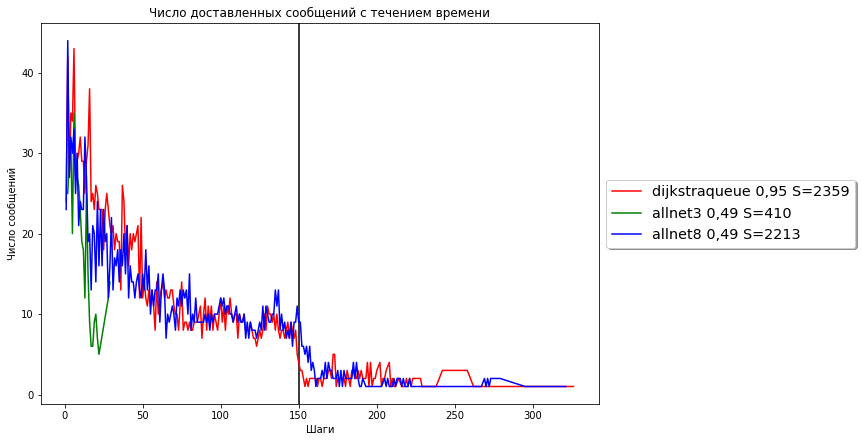

In [6]:
quantity = 1500;
log_tags = [
{"tag":  "d91d640a-e6e4-42e8-88a2-bd922b819d62", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f06636e6-b03f-4856-aaf9-06dbb8a8d74b", "label": "allnet3 0,49", "color": "green"},
{"tag":  "3fb6c04c-3755-454a-9a20-591068cfef11", "label": "allnet8 0,49", "color": "blue"},

]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 1304 Потеряно 97.1023% -dijkstraqueue 0,95
Доставлено 834 Потеряно 98.1467% -allnet3 0,49
Доставлено 1258 Потеряно 97.2045% -allnet8 0,49


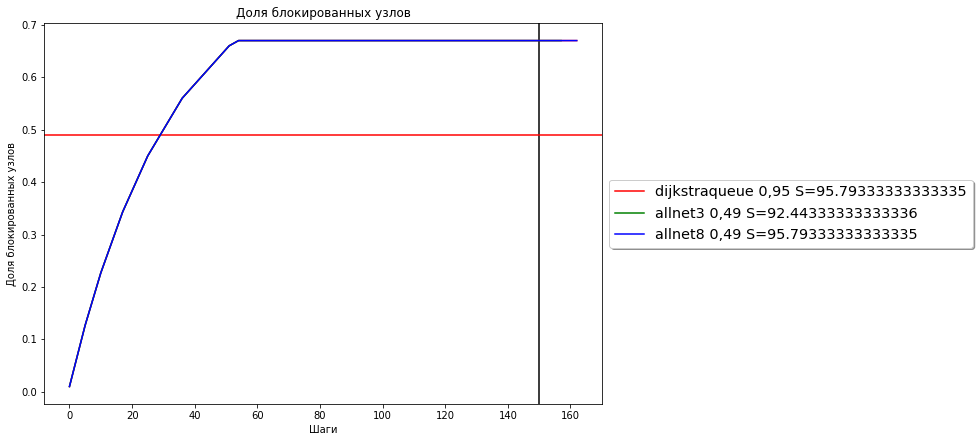

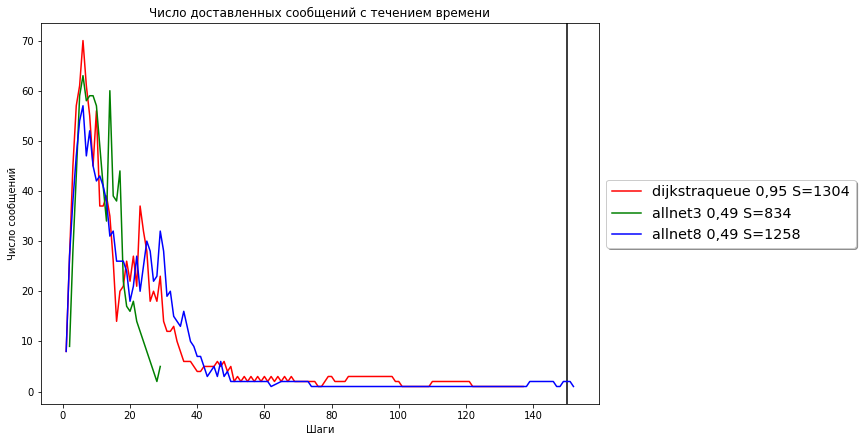

Доставлено 1632 Потеряно 98.4457% -dijkstraqueue 0,95
Доставлено 693 Потеряно 99.3400% -allnet3 0,49
Доставлено 1939 Потеряно 98.1534% -allnet8 0,49


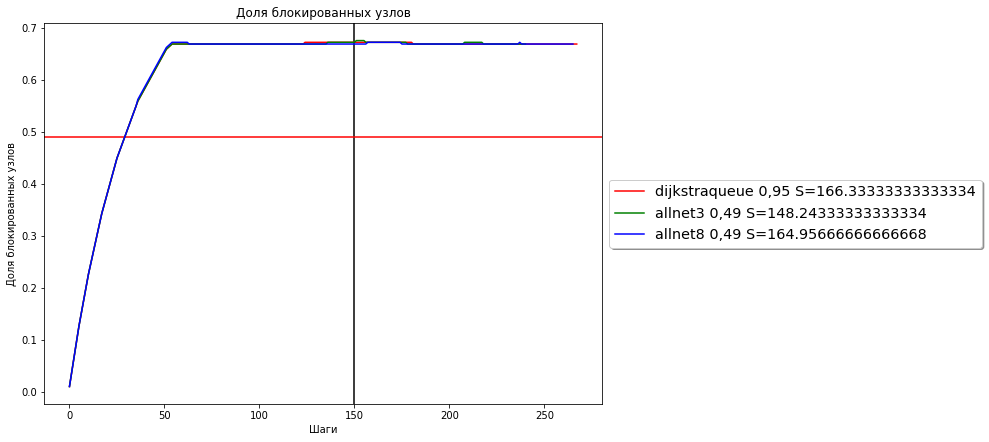

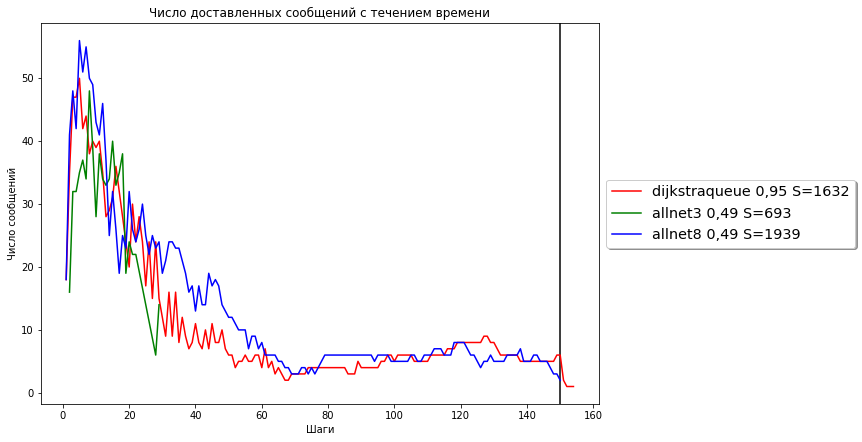

Доставлено 1919 Потеряно 98.5785% -dijkstraqueue 0,95
Доставлено 608 Потеряно 99.5496% -allnet3 0,49
Доставлено 2039 Потеряно 98.4896% -allnet8 0,49


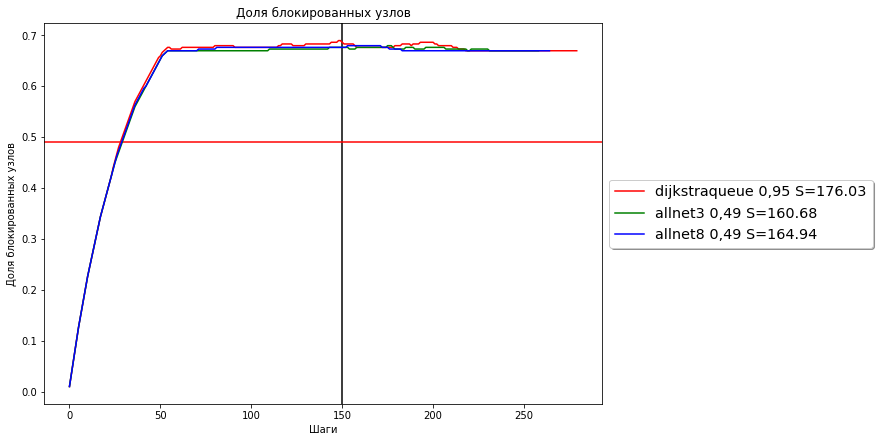

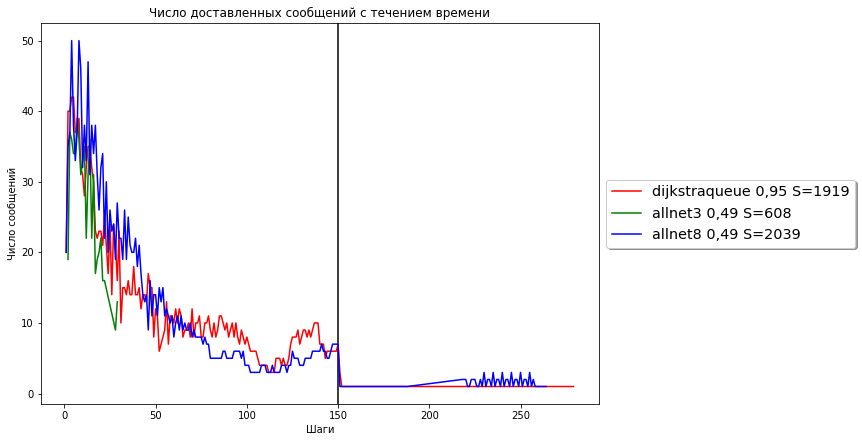

Доставлено 2065 Потеряно 98.9410% -dijkstraqueue 0,95
Доставлено 544 Потеряно 99.7210% -allnet3 0,49
Доставлено 2387 Потеряно 98.7759% -allnet8 0,49


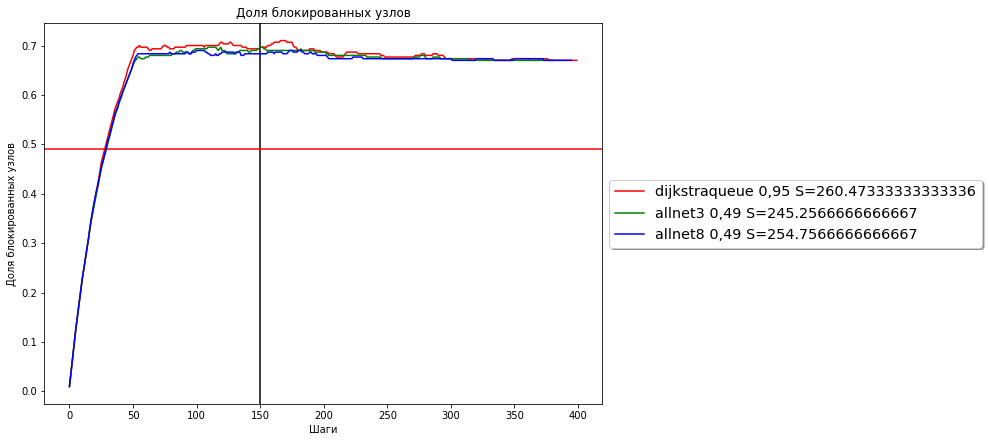

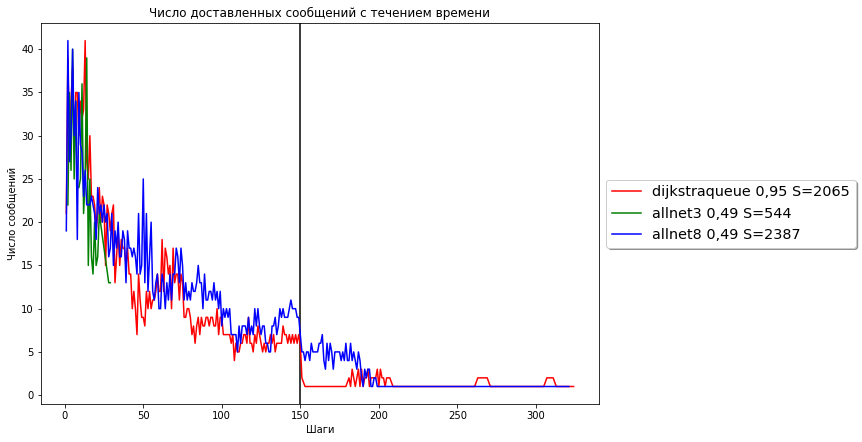

In [7]:
quantity = 300;
log_tags = [
{"tag":  "c0bd1979-a109-40ae-92df-daabe1926320", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "672b72b3-5b7a-4d78-bbff-009a5975b8e5", "label": "allnet3 0,49", "color": "green"},
{"tag":  "1463eb5d-466b-4852-8816-a95b0123dae9", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "6e72d24e-3e26-49fe-b91e-c96e9e53c2ed", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "a45ee213-0079-46c8-bba4-0e0069a54b71", "label": "allnet3 0,49", "color": "green"},
{"tag":  "1b035fc0-4276-4858-a58f-5e74633663b7", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "eb1cb8ab-8193-4512-8f53-aac9d8790bf9", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "456564b1-83fb-4580-9e81-72c285c77207", "label": "allnet3 0,49", "color": "green"},
{"tag":  "55ef1d79-7e90-4b9d-a958-acb75bd92605", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "09e79068-0ce4-4dd0-aa99-f785785aef1d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f576ab10-247a-40a0-8524-97e5c042411f", "label": "allnet3 0,49", "color": "green"},
{"tag":  "09265761-0bdd-44e9-8507-12a51e244a45", "label": "allnet8 0,49", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

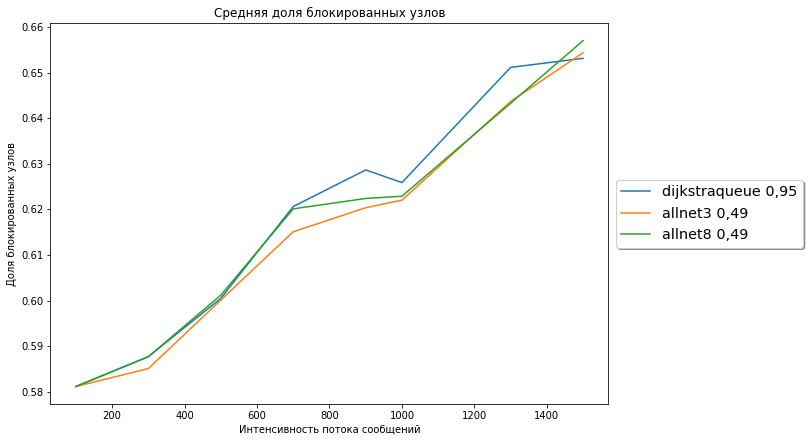

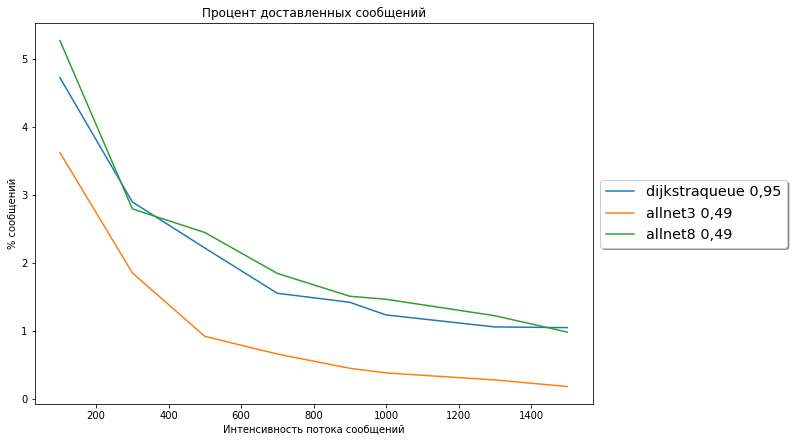

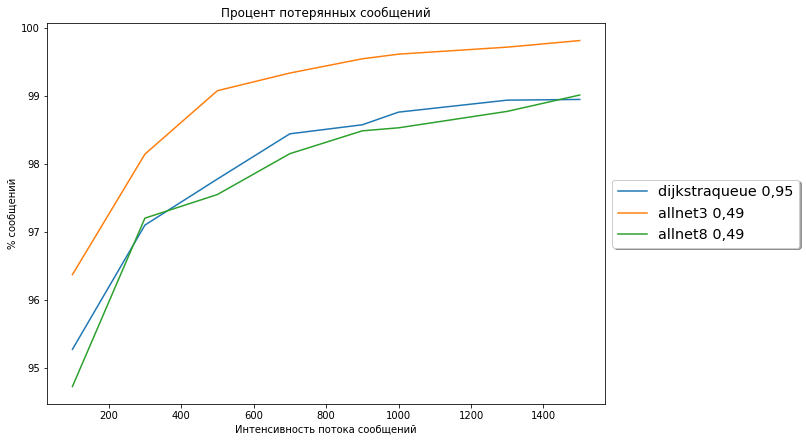

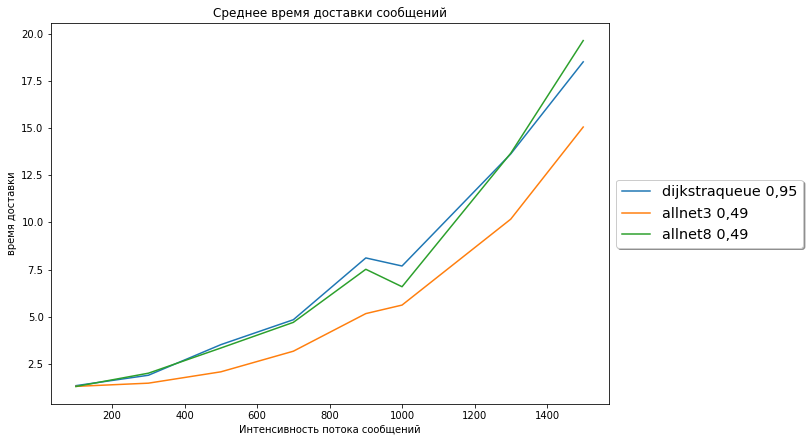

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()




In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())


dijkstraqueue 0,95    0.618614
allnet3 0,49          0.615252
allnet8 0,49          0.616986

dijkstraqueue 0,95    97.979686
allnet3 0,49          98.955843
allnet8 0,49          97.806614

dijkstraqueue 0,95    7.446784
allnet3 0,49          5.509614
allnet8 0,49          7.348192
